In [2]:
import os
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

sns.set(style="whitegrid")

In [3]:
path = kagglehub.dataset_download("vivekananda99/imdb-dataset")
print("Dataset downloaded to:", path)

Dataset downloaded to: /kaggle/input/imdb-dataset


In [4]:
for root, dirs, files in os.walk(path):
    level = root.replace(path, "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = " " * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

imdb-dataset/
    title.basics.tsv
    title.episode.tsv
    title.principals.tsv
    title.ratings.tsv
    name.basics.tsv
    title.akas.tsv
    title.crew.tsv


In [5]:
# Connect to DuckDB
con = duckdb.connect(database=':memory:')

basics_path = "/kaggle/input/imdb-dataset/title.basics.tsv"

con.execute(f"""
    CREATE TABLE title_basics AS 
    SELECT * FROM read_csv('{basics_path}', 
        delim='\t', 
        header=True, 
        nullstr='\\N'
    )
""")

# Check total rows
total_rows = con.execute("SELECT COUNT(*) FROM title_basics").fetchone()[0]
print(f"Total rows in title.basics: {total_rows:,}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total rows in title.basics: 12,009,132


In [6]:
# Display the table schema
schema_df = con.execute("PRAGMA table_info('title_basics')").fetchdf()
schema_df

,cid,name,type,notnull,dflt_value,pk
0,0,tconst,VARCHAR,False,None,False
1,1,titleType,VARCHAR,False,None,False
2,2,primaryTitle,VARCHAR,False,None,False
3,3,originalTitle,VARCHAR,False,None,False
4,4,isAdult,BIGINT,False,None,False
5,5,startYear,BIGINT,False,None,False
6,6,endYear,VARCHAR,False,None,False
7,7,runtimeMinutes,BIGINT,False,None,False
8,8,genres,VARCHAR,False,None,False


In [74]:
# Check for duplicate tconst values (unique identifier for titles)
duplicate_count = con.execute("""
    SELECT COUNT(*) - COUNT(DISTINCT tconst) AS duplicate_tconst_count
    FROM title_basics
""").fetchone()[0]

print(f"Number of duplicate tconst values: {duplicate_count}")

# Optional: Preview duplicate rows if any
if duplicate_count > 0:
    duplicate_rows = con.execute("""
        SELECT tconst, COUNT(*) AS count
        FROM title_basics
        GROUP BY tconst
        HAVING COUNT(*) > 1
        LIMIT 5
    """).fetchdf()
    display(duplicate_rows)
else:
    print("No duplicates found in tconst column.")

Number of duplicate tconst values: 0
No duplicates found in tconst column.


In [7]:
# preview first five rows
con.execute("SELECT * FROM title_basics LIMIT 5").fetchdf()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,None,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,None,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,None,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,None,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,None,1,Short


In [8]:
# display shape and column data types
row_count = con.execute("SELECT COUNT(*) AS total_rows FROM title_basics").fetchdf()
total_rows = int(row_count['total_rows'][0])
total_cols = len(schema_df)

print("Total rows:", f"{total_rows:,}")
print("Total columns:", total_cols)

schema_df[['name', 'type']]

Total rows: 12,009,132
Total columns: 9


,name,type
0,tconst,VARCHAR
1,titleType,VARCHAR
2,primaryTitle,VARCHAR
3,originalTitle,VARCHAR
4,isAdult,BIGINT
5,startYear,BIGINT
6,endYear,VARCHAR
7,runtimeMinutes,BIGINT
8,genres,VARCHAR


In [9]:
# count distinct values for key columns
unique_counts = con.execute("""
    SELECT 
        COUNT(DISTINCT tconst) AS unique_tconst,
        COUNT(DISTINCT titleType) AS unique_titleType,
        COUNT(DISTINCT primaryTitle) AS unique_primaryTitle,
        COUNT(DISTINCT originalTitle) AS unique_originalTitle,
        COUNT(DISTINCT isAdult) AS unique_isAdult,
        COUNT(DISTINCT startYear) AS unique_startYear,
        COUNT(DISTINCT endYear) AS unique_endYear,
        COUNT(DISTINCT runtimeMinutes) AS unique_runtimeMinutes,
        COUNT(DISTINCT genres) AS unique_genres
    FROM title_basics
""").fetchdf()

unique_counts

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,unique_tconst,unique_titleType,unique_primaryTitle,unique_originalTitle,unique_isAdult,unique_startYear,unique_endYear,unique_runtimeMinutes,unique_genres
0,12009132,11,5399820,5426587,2,153,98,973,2366


In [10]:
# summarize missing values and show percentages
missing_df = con.execute("""
    SELECT 
        SUM(CASE WHEN titleType IS NULL THEN 1 ELSE 0 END) AS missing_titleType,
        SUM(CASE WHEN primaryTitle IS NULL THEN 1 ELSE 0 END) AS missing_primaryTitle,
        SUM(CASE WHEN originalTitle IS NULL THEN 1 ELSE 0 END) AS missing_originalTitle,
        SUM(CASE WHEN isAdult IS NULL THEN 1 ELSE 0 END) AS missing_isAdult,
        SUM(CASE WHEN startYear IS NULL THEN 1 ELSE 0 END) AS missing_startYear,
        SUM(CASE WHEN endYear IS NULL THEN 1 ELSE 0 END) AS missing_endYear,
        SUM(CASE WHEN runtimeMinutes IS NULL THEN 1 ELSE 0 END) AS missing_runtimeMinutes,
        SUM(CASE WHEN genres IS NULL THEN 1 ELSE 0 END) AS missing_genres
    FROM title_basics
""").fetchdf()

missing_df_t = missing_df.T.reset_index()
missing_df_t.columns = ['column', 'missing_count']
missing_df_t['missing_percent'] = (missing_df_t['missing_count'] / total_rows) * 100
missing_df_t

,column,missing_count,missing_percent
0,missing_titleType,0.0,0.000000
1,missing_primaryTitle,0.0,0.000000
2,missing_originalTitle,0.0,0.000000
3,missing_isAdult,0.0,0.000000
4,missing_startYear,1441527.0,12.003590
5,missing_endYear,11860506.0,98.762392
6,missing_runtimeMinutes,7764390.0,64.654048
7,missing_genres,530193.0,4.414915


### Handling Missing Values

- **Columns with few missing values (`startYear`, `genres`)**: Can impute median (startYear) or "Unknown" (genres).  
- **Columns with very high missing values (`endYear`, `runtimeMinutes`)**:  
  - `endYear` → mostly for TV shows, keep NULL for movies.  
  - `runtimeMinutes` → too many missing values, use only rows with valid runtime when needed.  
- **Columns with no missing values (`titleType`, `primaryTitle`, `originalTitle`, `isAdult`)**: No action needed.

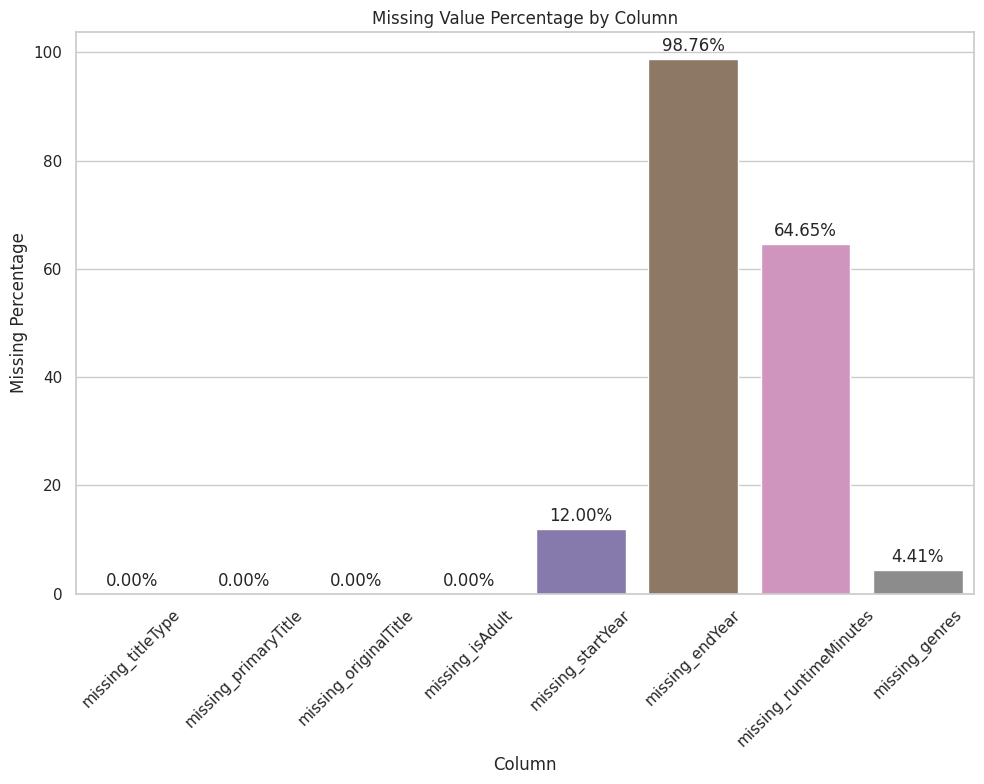

In [15]:
# visualize missing values with percent labels on bars
plt.figure(figsize=(10,8))
ax = sns.barplot(data=missing_df_t, x='column', y='missing_percent')

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%", padding=3)

plt.xticks(rotation=45)
plt.xlabel("Column")
plt.ylabel("Missing Percentage")
plt.title("Missing Value Percentage by Column")
plt.tight_layout()
plt.show()

### Why Some Columns Have Very High Missing Values?

- **`startYear` (~12% missing)**  
  Many titles in IMDB (especially upcoming projects or older archival entries) do not have a confirmed release year.  
  Example: films in early production or very old short films.

- **`endYear` (~98% missing)**  
  This column only applies to *TV series*, because it stores the final year a show ended.  
  Most IMDB titles are **movies, shorts, videos**, not TV shows → so this field stays empty.

- **`runtimeMinutes` (~65% missing)**  
  A large number of IMDB titles do not have verified runtime.  
  Older or obscure entries often lack proper runtime documentation.

- **`genres` (~4.4% missing)**  
  Some titles are uncategorized or belong to niche types where IMDB has not assigned genres.  
  Very small compared to others → generally good genre coverage.

**In summary:**  
Missing values are high mostly because IMDB includes *all* kinds of titles — old movies, unreleased projects, incomplete data, short clips, and non-movie records — leading to natural gaps in some fields.

In [20]:
# Load only startYear and runtimeMinutes (excluding NULLs)
df_outliers = con.execute("""
    SELECT 
        startYear,
        runtimeMinutes
    FROM title_basics
    WHERE startYear IS NOT NULL 
      AND runtimeMinutes IS NOT NULL
""").fetchdf()

df_outliers.head()

,startYear,runtimeMinutes
0,1894,1
1,1892,5
2,1892,5
3,1892,12
4,1893,1


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


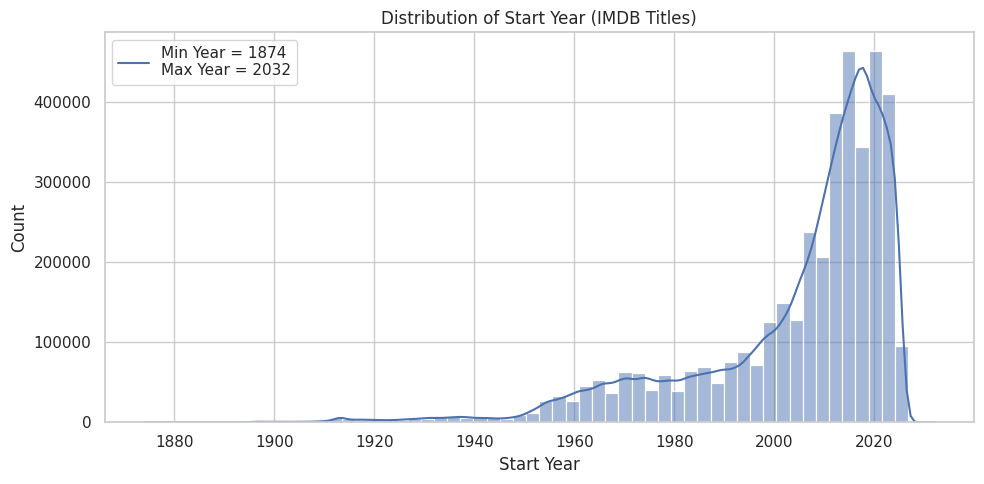

In [31]:
# Distribution of startYear with min/max in legend

min_year = int(df_outliers['startYear'].min())
max_year = int(df_outliers['startYear'].max())

plt.figure(figsize=(10, 5))
sns.histplot(df_outliers['startYear'], bins=60, kde=True)

# Title & labels
plt.title("Distribution of Start Year (IMDB Titles)")
plt.xlabel("Start Year")
plt.ylabel("Count")

# Add a simple legend showing min & max year
plt.legend([f"Min Year = {min_year}\nMax Year = {max_year}"], frameon=True)

plt.tight_layout()
plt.show()

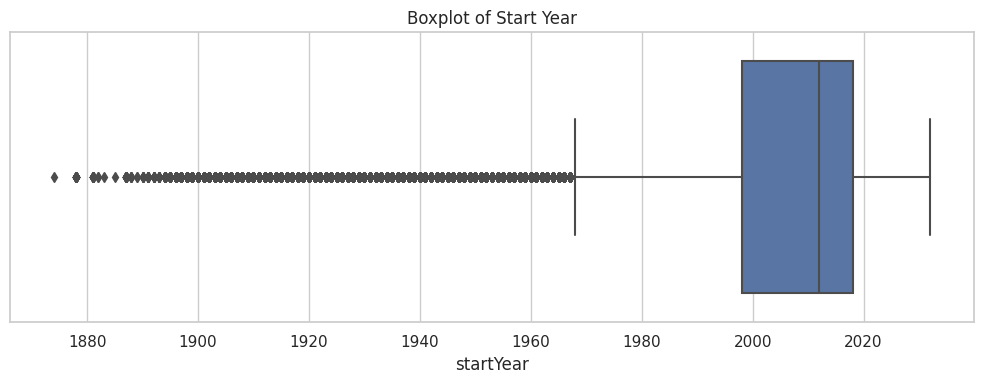

IQR Outlier Thresholds for startYear:
Lower Bound  = 1968.0
Upper Bound  = 2048.0

Number of startYear outliers: 289,813


In [32]:
# Boxplot + IQR outlier detection for startYear

plt.figure(figsize=(10, 4))
sns.boxplot(x=df_outliers['startYear'])
plt.title("Boxplot of Start Year")
plt.xlabel("startYear")
plt.tight_layout()
plt.show()

# Calculate IQR thresholds
Q1 = df_outliers['startYear'].quantile(0.25)
Q3 = df_outliers['startYear'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("IQR Outlier Thresholds for startYear:")
print(f"Lower Bound  = {lower_bound}")
print(f"Upper Bound  = {upper_bound}")

# Count outliers
outlier_count = df_outliers[
    (df_outliers['startYear'] < lower_bound) |
    (df_outliers['startYear'] > upper_bound)
].shape[0]

print(f"\nNumber of startYear outliers: {outlier_count:,}")

In [28]:
# Calculate percentage of outliers
total_rows = total_rows  
start_outliers_count = outlier_count 

start_outliers_percent = (start_outliers_count / total_rows) * 100

# Print results
print(f"Number of startYear outliers: {start_outliers_count:,}")
print(f"Percentage of startYear outliers: {start_outliers_percent:.2f}%\n")

Number of startYear outliers: 289,813
Percentage of startYear outliers: 2.41%



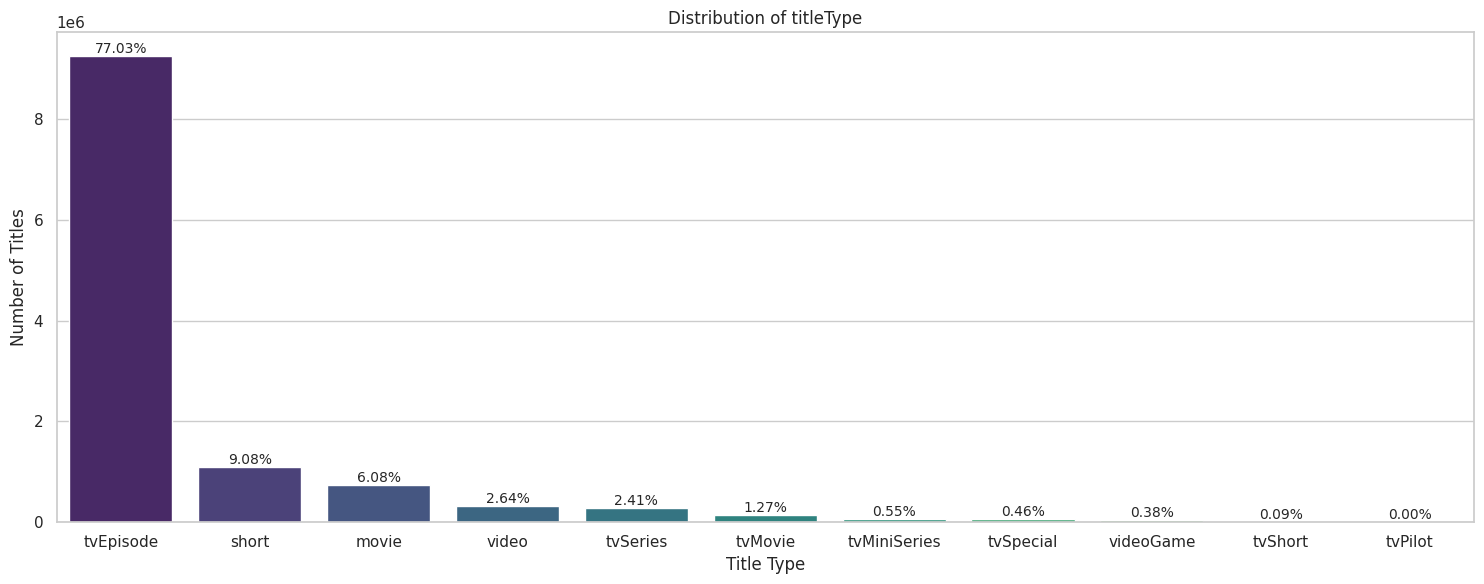

In [34]:
# Fetch titleType counts
title_counts = con.execute("""
    SELECT titleType, COUNT(*) AS count
    FROM title_basics
    GROUP BY titleType
    ORDER BY count DESC
""").fetchdf()

# Calculate percentage
title_counts['percent'] = (title_counts['count'] / title_counts['count'].sum()) * 100

# Plot
plt.figure(figsize=(15,6))
ax = sns.barplot(data=title_counts, x='titleType', y='count', palette='viridis')

# Add percent labels on bars
for i, row in title_counts.iterrows():
    ax.text(i, row['count'], f"{row['percent']:.2f}%", ha='center', va='bottom', fontsize=10)

plt.title("Distribution of titleType")
plt.xlabel("Title Type")
plt.ylabel("Number of Titles")
plt.tight_layout()
plt.show()

In [36]:
import pandas as pd

# Fetch all titleType + primary keys (tconst) for sampling
df_titleType = con.execute("""
    SELECT tconst, titleType
    FROM title_basics
""").fetchdf()

# Total sample size
sample_size = 200_000

# Calculate fraction per titleType
title_counts = df_titleType['titleType'].value_counts()
title_fraction = title_counts / title_counts.sum()

# Sample per titleType
sampled_list = []

for ttype, frac in title_fraction.items():
    n = int(frac * sample_size)
    sampled_rows = df_titleType[df_titleType['titleType'] == ttype].sample(n=n, random_state=42)
    sampled_list.append(sampled_rows)

# Concatenate stratified sample
stratified_sample = pd.concat(sampled_list).reset_index(drop=True)

# Check distribution
sample_dist = stratified_sample['titleType'].value_counts(normalize=True) * 100
print(f"Total rows in stratified sample: {stratified_sample.shape[0]}")
sample_dist

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total rows in stratified sample: 199994


titleType
tvEpisode       77.034811
short            9.084273
movie            6.076182
video            2.644579
tvSeries         2.411072
tvMovie          1.272038
tvMiniSeries     0.548516
tvSpecial        0.460014
videoGame        0.379011
tvShort          0.089503
Name: proportion, dtype: float64

In [41]:
stratified_sample.shape

(199994, 2)

In [42]:
# Fetch full data for stratified sample
sampled_tconsts = tuple(stratified_sample['tconst'].tolist())

df_sample_full = con.execute(f"""
    SELECT *
    FROM title_basics
    WHERE tconst IN {sampled_tconsts}
""").fetchdf()

In [43]:
df_sample_full.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0385271,short,Takaisin luontoon,Takaisin luontoon,0,2001,None,5,"Documentary,Short"
1,tt0385399,tvSeries,Delta State,Delta State,0,2004,None,22,"Animation,Sci-Fi"
2,tt0385596,video,Cherry Poppers 10: Sweet and Sassy,Cherry Poppers 10: Sweet and Sassy,1,1995,None,119,Adult
3,tt0385870,movie,The Chaser,Mihaengja,0,1976,None,100,Action
4,tt0385946,movie,Placeres divertidos,Placeres divertidos,0,1989,None,95,Comedy


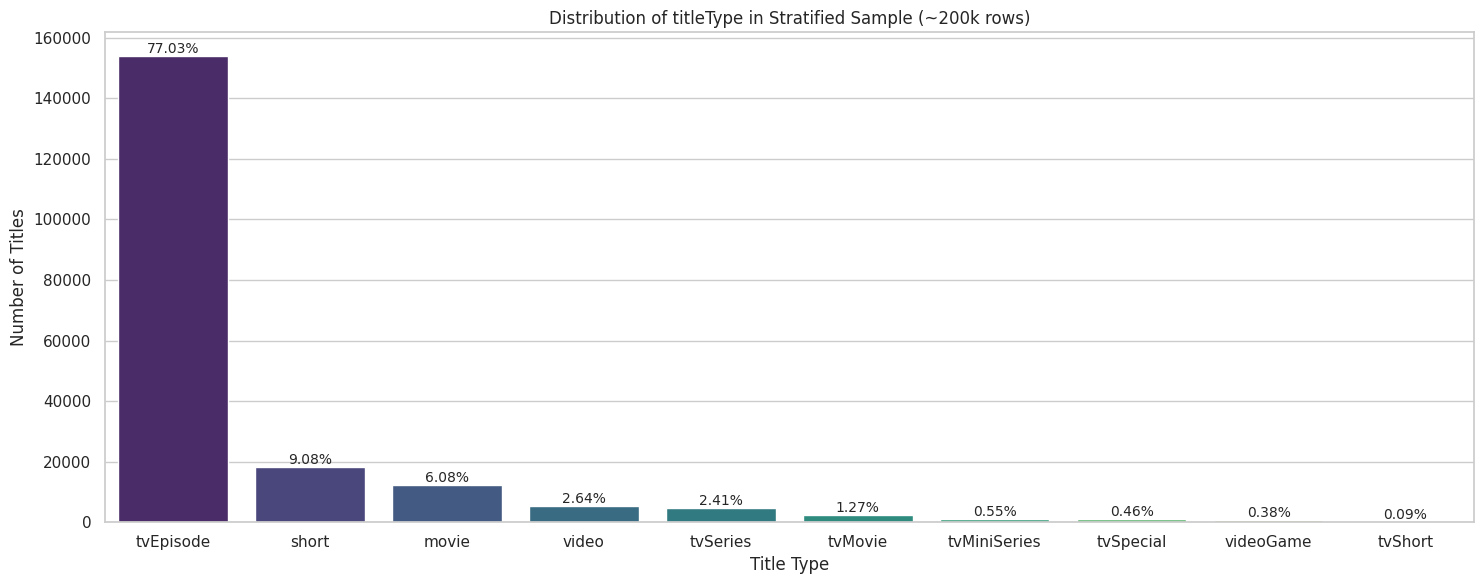

In [45]:
# Calculate counts and percentages for sampled data
sample_title_counts = df_sample_full['titleType'].value_counts().reset_index()
sample_title_counts.columns = ['titleType', 'count']
sample_title_counts['percent'] = (sample_title_counts['count'] / sample_title_counts['count'].sum()) * 100

# Plot
plt.figure(figsize=(15,6))
ax = sns.barplot(data=sample_title_counts, x='titleType', y='count', palette='viridis')

# Add percent labels on bars
for i, row in sample_title_counts.iterrows():
    ax.text(i, row['count'], f"{row['percent']:.2f}%", ha='center', va='bottom', fontsize=10)

plt.title("Distribution of titleType in Stratified Sample (~200k rows)")
plt.xlabel("Title Type")
plt.ylabel("Number of Titles")
plt.tight_layout()
plt.show()

In [46]:
# Replace missing genres with 'Unknown' to avoid errors
df_sample_full['genres'] = df_sample_full['genres'].fillna('Unknown')

# Split genres into lists
df_sample_full['genres_list'] = df_sample_full['genres'].str.split(',')

# Explode the lists into separate rows
df_genres_exploded = df_sample_full.explode('genres_list')

# Rename column for clarity
df_genres_exploded = df_genres_exploded.rename(columns={'genres_list': 'genre'})

# Check the exploded table
df_genres_exploded[['tconst', 'primaryTitle', 'genre']].head(10)

,tconst,primaryTitle,genre
0,tt0385271,Takaisin luontoon,Documentary
0,tt0385271,Takaisin luontoon,Short
1,tt0385399,Delta State,Animation
1,tt0385399,Delta State,Sci-Fi
2,tt0385596,Cherry Poppers 10: Sweet and Sassy,Adult
3,tt0385870,The Chaser,Action
4,tt0385946,Placeres divertidos,Comedy
5,tt0386267,A bor lelke,Short
6,tt0386330,The Bill Collector,Drama
6,tt0386330,The Bill Collector,Short


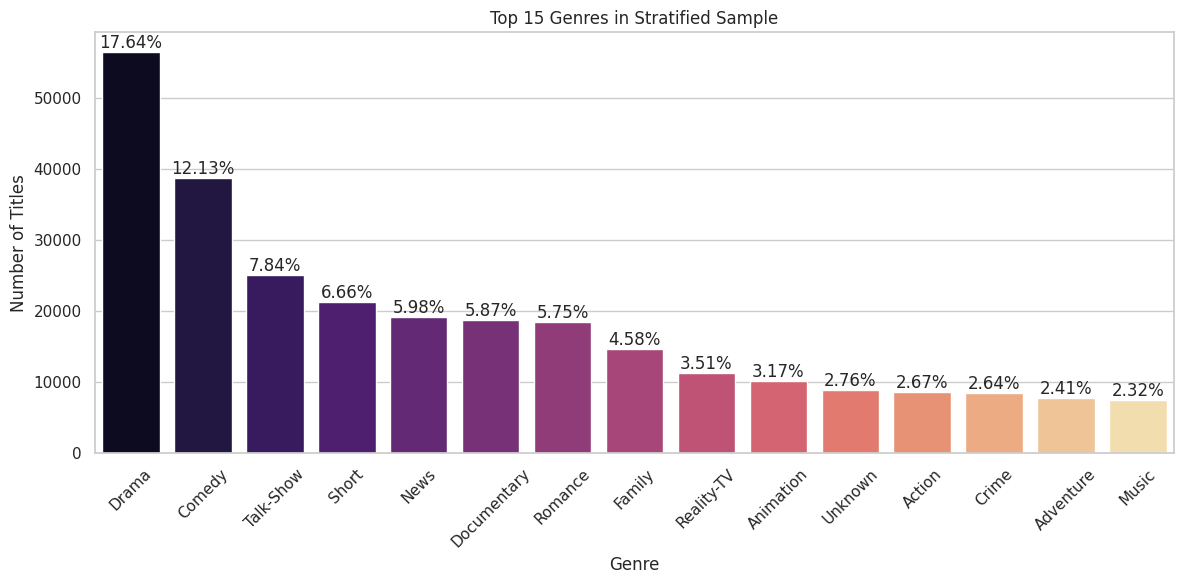

In [49]:
# Count titles per genre
genre_counts = df_genres_exploded['genre'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Calculate percentage
genre_counts['percent'] = (genre_counts['count'] / genre_counts['count'].sum()) * 100

# Take top 15 genres for visualization
top_genres = genre_counts.head(15)

# Plot
plt.figure(figsize=(12,6))
ax = sns.barplot(data=top_genres, x='genre', y='count', palette='magma')

# Add percent labels
for i, row in top_genres.iterrows():
    ax.text(i, row['count'], f"{row['percent']:.2f}%", ha='center', va='bottom')

plt.title("Top 15 Genres in Stratified Sample")
plt.xlabel("Genre")
plt.ylabel("Number of Titles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

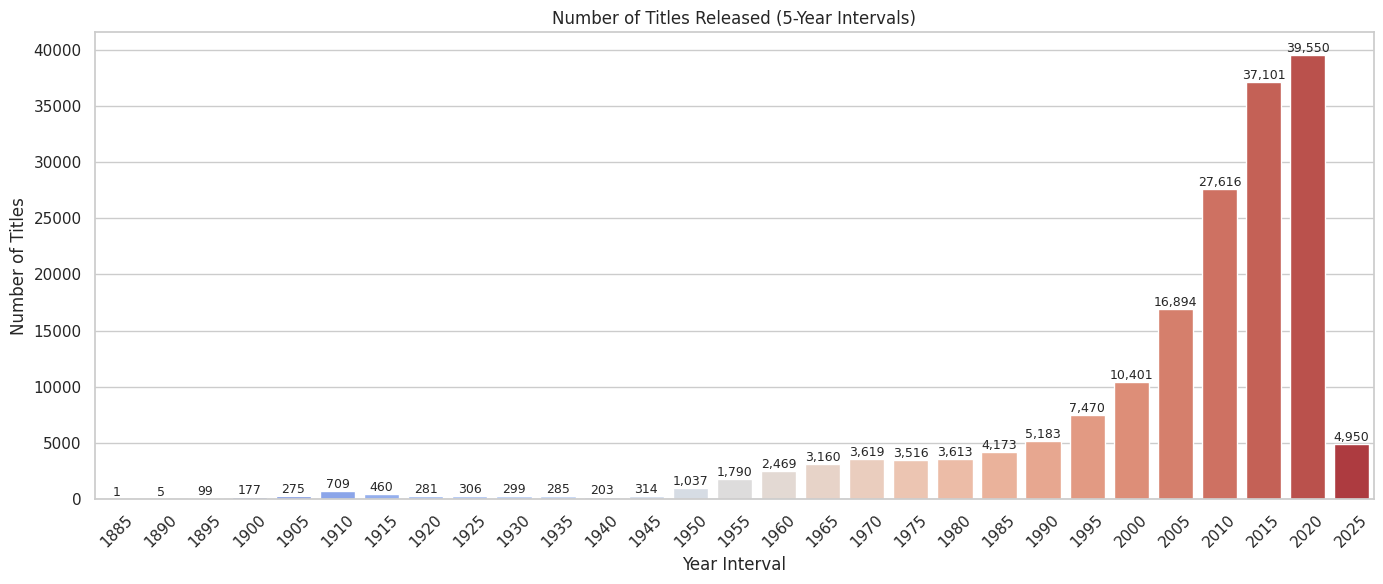

In [52]:
# Ensure startYear is numeric and drop missing
df_year = df_sample_full.copy()
df_year['startYear'] = pd.to_numeric(df_year['startYear'], errors='coerce')
df_year = df_year.dropna(subset=['startYear'])

# Group by 5-year intervals
df_year['year_group'] = (df_year['startYear'] // 5) * 5

annual_grouped = df_year.groupby('year_group').size().reset_index(name='count')

# Plot
plt.figure(figsize=(14,6))
sns.barplot(data=annual_grouped, x='year_group', y='count', palette='coolwarm')

# Add labels on bars
for i, row in annual_grouped.iterrows():
    plt.text(i, row['count'], f"{row['count']:,}", ha='center', va='bottom', fontsize=9)

plt.title("Number of Titles Released (5-Year Intervals)")
plt.xlabel("Year Interval")
plt.ylabel("Number of Titles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

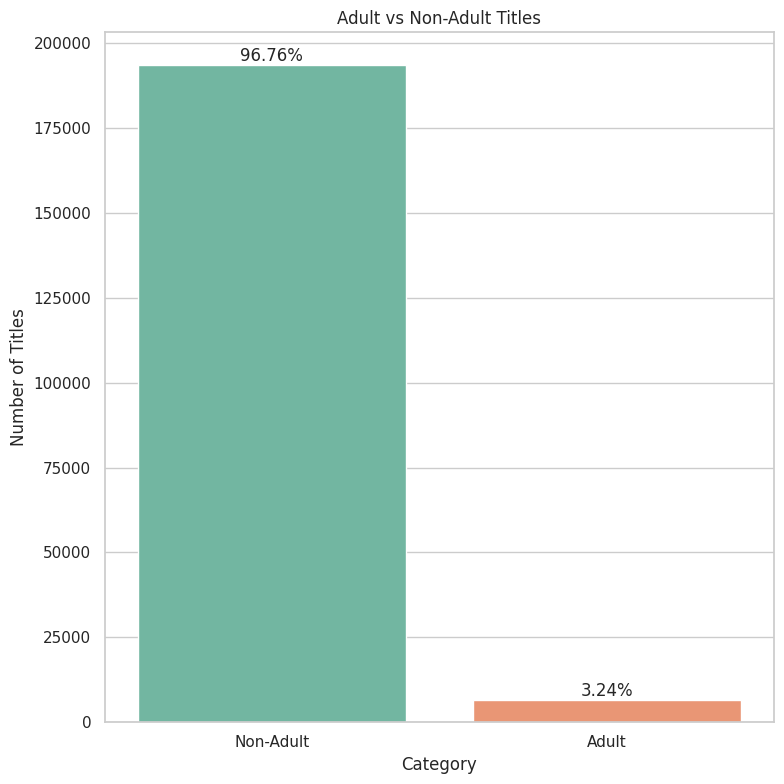

In [56]:
# Count adult vs non-adult titles
adult_counts = df_sample_full['isAdult'].value_counts().reset_index()
adult_counts.columns = ['isAdult', 'count']

# Map 0/1 to labels
adult_counts['label'] = adult_counts['isAdult'].map({0: 'Non-Adult', 1: 'Adult'})

# Calculate percentage
adult_counts['percent'] = (adult_counts['count'] / adult_counts['count'].sum()) * 100

# Plot
plt.figure(figsize=(8,8))
ax = sns.barplot(data=adult_counts, x='label', y='count', palette='Set2')

# Add percent labels
for i, row in adult_counts.iterrows():
    ax.text(i, row['count'], f"{row['percent']:.2f}%", ha='center', va='bottom')

plt.title("Adult vs Non-Adult Titles")
plt.xlabel("Category")
plt.ylabel("Number of Titles")
plt.tight_layout()
plt.show()

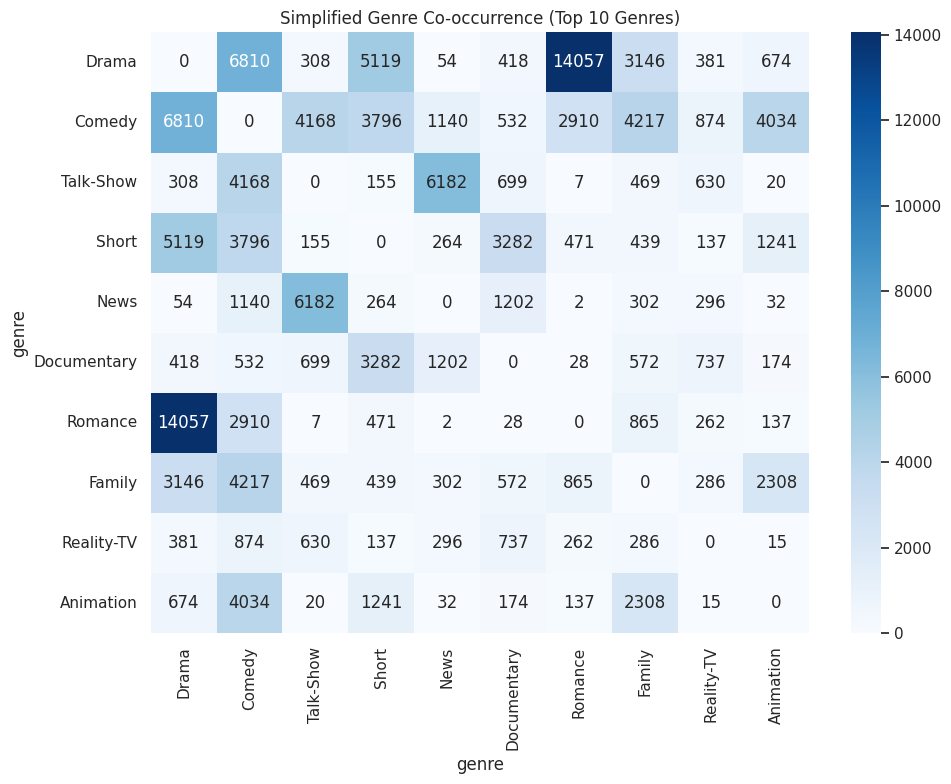

In [59]:
# Top 10 genres by frequency
top_10_genres = df_genres_exploded['genre'].value_counts().head(10).index

# Filter exploded data to top 10 genres
df_top10 = df_genres_exploded[df_genres_exploded['genre'].isin(top_10_genres)]

# Create co-occurrence matrix
co_matrix_simple = pd.DataFrame(0, index=top_10_genres, columns=top_10_genres)

for tconst, group in df_top10.groupby('tconst'):
    genres = group['genre'].tolist()
    for i in range(len(genres)):
        for j in range(i+1, len(genres)):  # only upper triangle to avoid double-counting
            co_matrix_simple.loc[genres[i], genres[j]] += 1
            co_matrix_simple.loc[genres[j], genres[i]] += 1  # symmetric

# Remove diagonal for clarity
np.fill_diagonal(co_matrix_simple.values, 0)

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(co_matrix_simple, annot=True, fmt='d', cmap='Blues')
plt.title("Simplified Genre Co-occurrence (Top 10 Genres)")
plt.tight_layout()
plt.show()

In [60]:
from itertools import combinations
from collections import Counter

# Only consider top 10 genres to simplify
top_10_genres = df_genres_exploded['genre'].value_counts().head(10).index
df_top10 = df_genres_exploded[df_genres_exploded['genre'].isin(top_10_genres)]

# Generate all genre pairs for each title
genre_pairs = []
for tconst, group in df_top10.groupby('tconst'):
    genres = sorted(group['genre'].tolist())
    # combinations of 2 genres
    pairs = list(combinations(genres, 2))
    genre_pairs.extend(pairs)

# Count frequency of each pair
pair_counts = Counter(genre_pairs)

# Convert to DataFrame and get top 5
top_5_pairs = pd.DataFrame(pair_counts.most_common(5), columns=['Genre Pair', 'Count'])
top_5_pairs

,Genre Pair,Count
0,"(Drama, Romance)",14057
1,"(Comedy, Drama)",6810
2,"(News, Talk-Show)",6182
3,"(Drama, Short)",5119
4,"(Comedy, Family)",4217


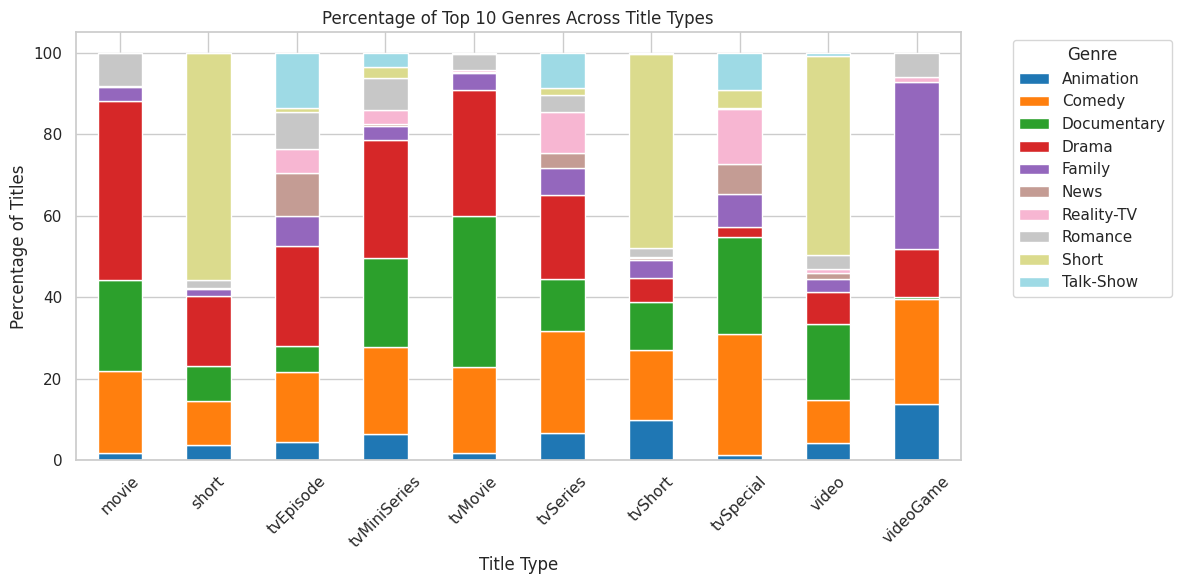

In [65]:
# Only top 10 genres for clarity
top_10_genres = df_genres_exploded['genre'].value_counts().head(10).index
df_top10 = df_genres_exploded[df_genres_exploded['genre'].isin(top_10_genres)]

# Count titles per titleType and genre
title_genre_counts = df_top10.groupby(['titleType', 'genre']).size().unstack(fill_value=0)

# Convert counts to percentages per titleType
title_genre_percent = title_genre_counts.div(title_genre_counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart with percentages
title_genre_percent.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')

plt.title("Percentage of Top 10 Genres Across Title Types")
plt.xlabel("Title Type")
plt.ylabel("Percentage of Titles")
plt.xticks(rotation=45)
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [66]:
# Count genres per titleType
title_genre_counts = df_genres_exploded.groupby(['titleType', 'genre']).size().reset_index(name='count')

# For each titleType, get the genre with the max count
dominant_genre_per_type = title_genre_counts.loc[title_genre_counts.groupby('titleType')['count'].idxmax()]

# Keep only relevant columns
dominant_genre_per_type = dominant_genre_per_type[['titleType', 'genre', 'count']]
dominant_genre_per_type

,titleType,genre,count
8,movie,Drama,4511
48,short,Short,17236
62,tvEpisode,Drama,44253
90,tvMiniSeries,Drama,289
116,tvMovie,Documentary,816
141,tvSeries,Comedy,1108
183,tvShort,Short,157
201,tvSpecial,Music,219
232,video,Short,2214
239,videoGame,Action,310


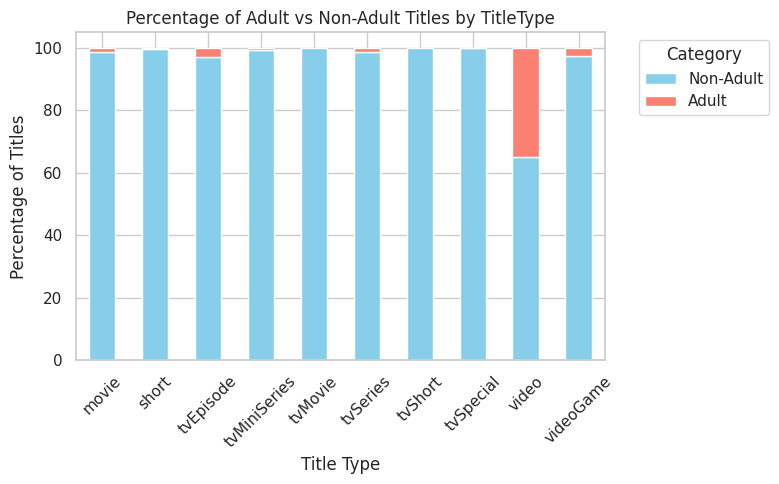

In [67]:
# Count isAdult per titleType
adult_counts = df_sample_full.groupby(['titleType', 'isAdult']).size().unstack(fill_value=0)

# Convert counts to percentages per titleType
adult_percent = adult_counts.div(adult_counts.sum(axis=1), axis=0) * 100

# Rename columns for clarity
adult_percent.columns = ['Non-Adult', 'Adult']

# Plot
adult_percent.plot(kind='bar', stacked=True, figsize=(8,5), color=['skyblue', 'salmon'])

plt.title("Percentage of Adult vs Non-Adult Titles by TitleType")
plt.xlabel("Title Type")
plt.ylabel("Percentage of Titles")
plt.xticks(rotation=45)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

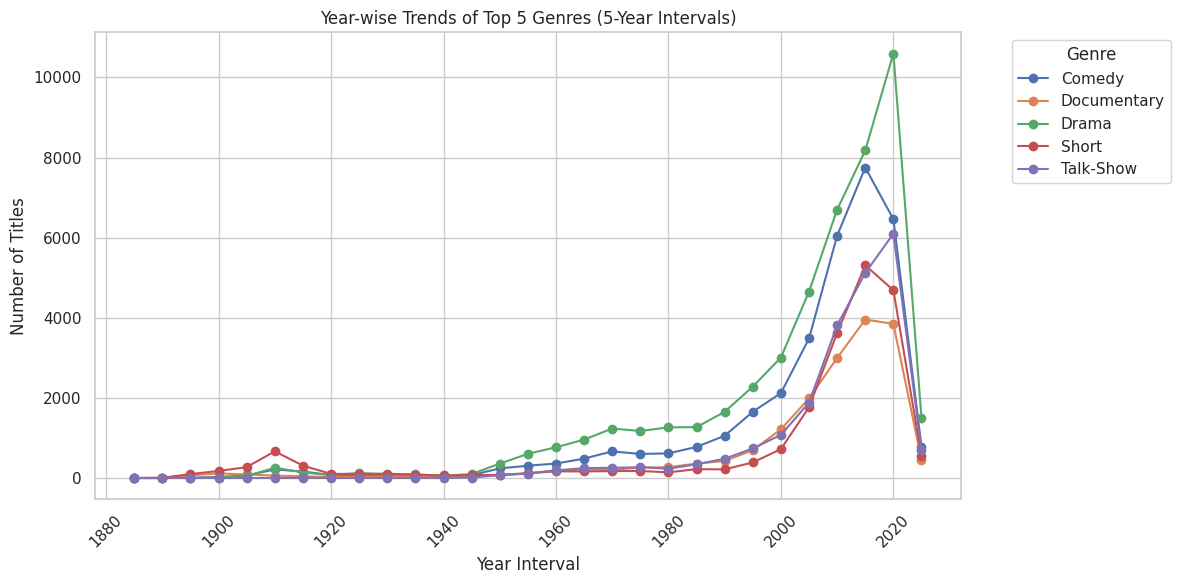

In [68]:
# Ensure startYear is numeric and drop missing
df_year_genre = df_genres_exploded.copy()
df_year_genre['startYear'] = pd.to_numeric(df_year_genre['startYear'], errors='coerce')
df_year_genre = df_year_genre.dropna(subset=['startYear'])

# Aggregate into 5-year intervals
df_year_genre['year_group'] = (df_year_genre['startYear'] // 5) * 5

# Top 5 genres overall
top_5_genres = df_year_genre['genre'].value_counts().head(5).index
df_top5 = df_year_genre[df_year_genre['genre'].isin(top_5_genres)]

# Count titles per year_group and genre
year_genre_counts = df_top5.groupby(['year_group', 'genre']).size().unstack(fill_value=0)

# Plot
year_genre_counts.plot(kind='line', figsize=(12,6), marker='o')

plt.title("Year-wise Trends of Top 5 Genres (5-Year Intervals)")
plt.xlabel("Year Interval")
plt.ylabel("Number of Titles")
plt.xticks(rotation=45)
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [77]:
import plotly.express as px

# Count titles per genre
genre_counts = df_genres_exploded['genre'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Treemap
fig = px.treemap(
    genre_counts,
    path=['genre'],  
    values='count',
    title='Treemap of IMDb Genres'
)
fig.show()

# Exploratory Data Analysis (EDA) Summary

### 1. Dataset Overview
- Dataset contains **12M+ titles** with 9 columns (`tconst`, `titleType`, `primaryTitle`, `originalTitle`, `isAdult`, `startYear`, `endYear`, `runtimeMinutes`, `genres`).
- Key columns like `titleType`, `primaryTitle`, `isAdult` have **no missing values**.
- Columns with high missing percentages:
  - `endYear`: 98.76% missing  
  - `runtimeMinutes`: 64.65% missing  
  - `startYear`: 12% missing  

### 2. Outlier Analysis
- `startYear` outliers detected using IQR: **289,813 titles (~14%)**, mostly very early years.
- Outliers in `runtimeMinutes` not analyzed due to excessive missing data.

### 3. Stratified Sampling
- Created a **sample of 200,000 titles** preserving `titleType` distribution for faster analysis.

### 4. TitleType Distribution
- Most common types: **movie**, **short**, **tvEpisode**.
- Distribution maintained in stratified sample.

### 5. Genre Analysis
- Exploded multi-genre titles for accurate analysis.
- Top 5 genres: **Drama, Comedy, Action, Short, Documentary**.
- **Top genre pairs**: e.g., (Action, Adventure), (Comedy, Drama).

### 6. Temporal Trends
- **Annual releases** show growth over time; 5-year intervals used for clarity.
- **Year-wise genre trends**: Drama, Comedy, Action steadily increased over decades.

### 7. Adult Content Analysis
- Most titles are **non-adult**.
- Slightly higher proportion of adult content in TV Episodes compared to other types.

### 8. TitleType vs Genre
- Percentage stacked bars show **genre composition per titleType**.
- Dominant genres per titleType:
  - Shorts → Short  
  - Movies → Drama  
  - TV Episodes → Drama

### Key Takeaways
- **Drama and Comedy dominate movies and TV episodes**.  
- **Shorts are almost entirely the "Short" genre**.  
- Genre popularity has increased steadily over time.  
- Adult content is relatively rare across all title types.


----
# SUMMARY TABLE

In [73]:
# 1. TitleType counts & percentages
title_type_counts = df_sample_full['titleType'].value_counts()
title_type_percent = df_sample_full['titleType'].value_counts(normalize=True) * 100

# 2. Adult content counts & percentages
adult_counts = df_sample_full['isAdult'].value_counts()
adult_percent = df_sample_full['isAdult'].value_counts(normalize=True) * 100

# 3. StartYear stats
start_year_stats = df_sample_full['startYear'].describe()
start_year_stats = start_year_stats[['min','25%','50%','mean','75%','max']]

# 4. Top 5 genres
top_genres = df_genres_exploded['genre'].value_counts().head(5)

# Combine everything into a single DataFrame
summary_dict = {
    'Metric': [
        'Total Titles',
        'Movies Count',
        'Movies %',
        'Shorts Count',
        'Shorts %',
        'TV Episodes Count',
        'TV Episodes %',
        'Non-Adult Count',
        'Non-Adult %',
        'Adult Count',
        'Adult %',
        'Start Year Min',
        'Start Year 25%',
        'Start Year Median',
        'Start Year Mean',
        'Start Year 75%',
        'Start Year Max',
        'Top Genre 1',
        'Top Genre 2',
        'Top Genre 3',
        'Top Genre 4',
        'Top Genre 5'
    ],
    'Value': [
        len(df_sample_full),
        title_type_counts.get('movie', 0),
        round(title_type_percent.get('movie', 0),2),
        title_type_counts.get('short', 0),
        round(title_type_percent.get('short', 0),2),
        title_type_counts.get('tvEpisode', 0),
        round(title_type_percent.get('tvEpisode', 0),2),
        adult_counts.get(0,0),
        round(adult_percent.get(0,0),2),
        adult_counts.get(1,0),
        round(adult_percent.get(1,0),2),
        int(start_year_stats['min']),
        int(start_year_stats['25%']),
        int(start_year_stats['50%']),
        round(start_year_stats['mean'],2),
        int(start_year_stats['75%']),
        int(start_year_stats['max']),
        top_genres.index[0],
        top_genres.index[1],
        top_genres.index[2],
        top_genres.index[3],
        top_genres.index[4]
    ]
}

summary_table = pd.DataFrame(summary_dict)
summary_table

,Metric,Value
0,Total Titles,199994
1,Movies Count,12152
2,Movies %,6.08
3,Shorts Count,18168
4,Shorts %,9.08
5,TV Episodes Count,154065
6,TV Episodes %,77.03
7,Non-Adult Count,193509
8,Non-Adult %,96.76
9,Adult Count,6485
